The following tutorial is based on Koch et al. (2007) PRA. It models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable.

#Import key modules for this demo

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

In [7]:
!pip install PySide2
!pip install qiskit-metal

In [11]:
import os

# Set this environment variable to prevent qiskit-metal from trying to set up a Qt backend
os.environ["QISKIT_METAL_HEADLESS"] = "1"

In [12]:
# Now import qiskit_metal
import qiskit_metal

In [15]:
from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [74]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scqubits as scq

#The Hamiltonian

The Hamiltonian of the transmon qubit in the can be written in the charge basis as:

\begin{align}
        H = 4E_C(\hat{n} - n_g)^2 - \frac{1}{2}E_J\sum_n\left(
          \left| n \right \rangle \left \langle n+1 \right | + \text{h.c.}  \right)
\end{align}

In [76]:
tmon = scq.Transmon.create()
print(tmon)

For use with jupyter lab, additionally execute `jupyter labextension install jupyter-vuetify`.

 /usr/local/lib/python3.11/dist-packages/scqubits/utils/misc.py: 143


Transmon------------| [Transmon_9]
                    | EJ: 15.0
                    | EC: 0.3
                    | ng: 0.0
                    | ncut: 30
                    | truncated_dim: 10
                    |
                    | dim: 61



In [79]:
x = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
H_norm = Hcpb(nlevels=2, Ej=1000.0, Ec=1000.0, ng=0.5) # Hamiltonian definition
norm = H_norm.fij(0,1) # normalization constant

In [80]:
E0, E1, E2 = [], [], []

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x:
    H = Hcpb(nlevels=30, Ej=15.0, Ec=0.3, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)


#Verifying Orthonormality of the Wavefunctions



In [81]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

(8.326672684688674e-17-7.392060725770952e-18j)
(0.9999999999999996+0j)
(0.9999999999999998+0j)


#Charge dispersion

The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_m = E_m(n_g=0.5)-E_m(n_g=0.0)$. We can plot $\epsilon_m/E_{01}$ as a function of $E_J/E_C$ for the first few energy levels and reproduce the figure published in Phys. Rev. A 76, 042319 (2007) (Figure 4(a)). We can start by defining a value of charging energy and creating empty lists for $\epsilon_0$ through $\epsilon_4$

In [83]:
E_c=100.0 # charging energy
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)

#Anharmonicity

We know that for the transmon qubit, having the Josephson Energy much larger than the charging energy ($E_J>>E_C$) results in a decrease in anharmonicity. The latter is critical for a functional qubit in which the energy difference between the lowest two states ($E_{01}$) is sufficiently different than the energy difference between the second and third states, ($E_{12}$). The absolute anharmonicity is defined as $\alpha = E_{12}-E_{01}$, while the relative anharmonicity is defined as
.

We can easily make a plot of the anharmonicity as a function of $E_J/E_C$ using the Hcpb class. Let’s have the ratio of $E_J/E_C$ (which we’ll call x) vary from 0 to 80, and then we’ll create empty lists for $\alpha$ and $\alpha_r$



In [82]:
x = np.linspace(0,80,101)   #EJ/EC
alpha = []
alpha_r = []

In [84]:
for i in x:
    H_anharm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    alpha.append(H_anharm.anharm())
    alpha_r.append(H_anharm.anharm()/H_anharm.fij(0,1))

Text(0, 0.5, 'alpha_r')

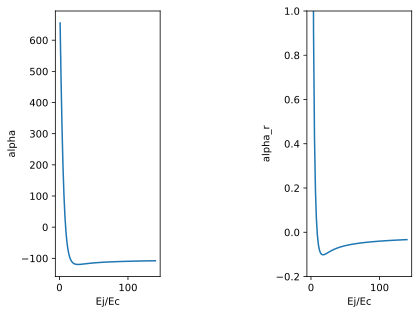

In [85]:
plt.figure(1)
plt.subplot(131)
plt.plot(x,alpha)
plt.xlabel("Ej/Ec")
plt.ylabel("alpha")
plt.subplot(133)
plt.plot(x,alpha_r)
plt.ylim(-0.2, 1.0)
plt.xlabel("Ej/Ec")
plt.ylabel("alpha_r")

#Dephasing Time (T2)

We can estimate the qubit dephasing time (T2) due to charge noise by the following expression: $T_2 = \frac{\hbar}{A\pi |\epsilon_1|}$ where $A$ is on the order of $1E-4$
 according to Phys. Rev. A 76, 042319 (2007). Since this is essentially just the inverse of the charge dispersion for $\epsilon_1$, we can easily calculate T2 as a function of $E_J/E_C$ with the following:

In [86]:
x = np.linspace(0,80,101)     # ratio of Ej/Ec, varying from 0 to 80
T2 = []                       # empty list for T2

Text(0, 0.5, 'T2 (sec)')

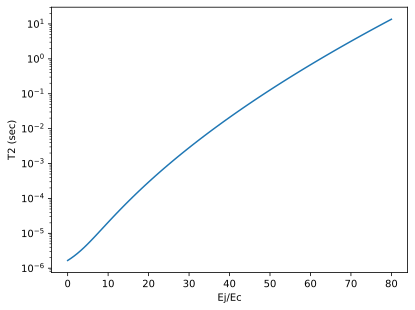

In [87]:
E_c = 1000.0
for i in x:
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    eps = abs(H_half.evalue_k(1) - H_zero.evalue_k(1))
    T2.append(1.0/(2.0*(1E-4)*(1E6)*eps) )

plt.plot(x, T2)
plt.yscale("log")
plt.xlabel("Ej/Ec")
plt.ylabel("T2 (sec)")

Operator matrix elements visualized with text representation of each entry.

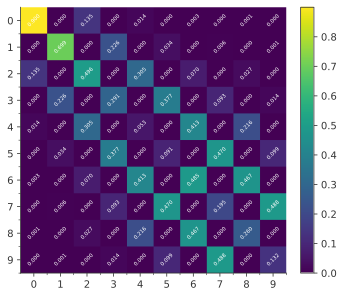

In [117]:
tmon.plot_matrixelements('cos_phi_operator', evals_count=10, show3d=False, show_numbers=True);
